Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [3]:

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
train_path="gdrive/My Drive/CNN_assignment/Train/"
test_path="gdrive/My Drive/CNN_assignment/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2243
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.



1.   Create Training Dataset









In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2243 files belonging to 9 classes.
Using 1795 files for training.




2.   Create Validation dataset



In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2243 files belonging to 9 classes.
Using 448 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

Create a code to visualize one instance of all the nine classes present in the dataset

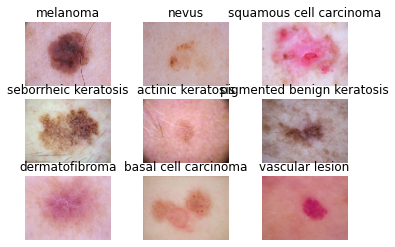

In [10]:
import matplotlib.pyplot as plt
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
     

### Create the model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

### Model #1

In [12]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Compile the model

Choose an appropirate optimiser and loss function for model training

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 289s 1s/step - loss: 3.1821 - accuracy: 0.2117 - val_loss: 1.8950 - val_accuracy: 0.3549
Epoch 2/20
57/57 [==============================] - 3s 58ms/step - loss: 1.8079 - accuracy: 0.3526 - val_loss: 1.8973 - val_accuracy: 0.3036
Epoch 3/20
57/57 [==============================] - 3s 57ms/step - loss: 1.6208 - accuracy: 0.4368 - val_loss: 1.6969 - val_accuracy: 0.4732
Epoch 4/20
57/57 [==============================] - 3s 55ms/step - loss: 1.5539 - accuracy: 0.4585 - val_loss: 1.4604 - val_accuracy: 0.5290
Epoch 5/20
57/57 [==============================] - 3s 56ms/step - loss: 1.4363 - accuracy: 0.4969 - val_loss: 1.4714 - val_accuracy: 0.5201
Epoch 6/20
57/57 [==============================] - 3s 58ms/step - loss: 1.4249 - accuracy: 0.5103 - val_loss: 1.5193 - val_accuracy: 0.4665
Epoch 7/20
57/57 [==============================] - 3s 60ms/step - loss: 1.3733 - accuracy: 0.5292 - val_loss: 1.4177 - val_accuracy: 0.5045
Epoch 8/20
57

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Visualizing training results

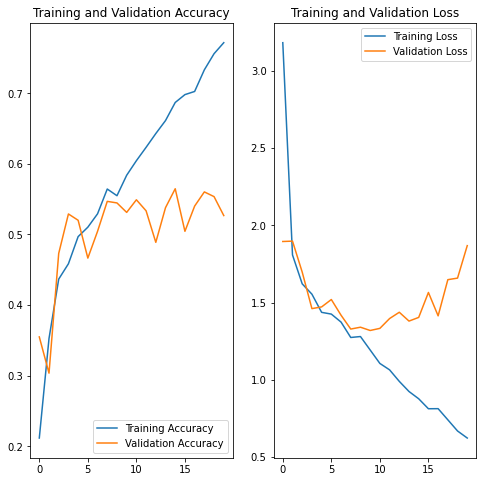

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observations



1.   As observed, the accuracy of the model on training dataset after 20 epochs is 77.16% whereas validation accuracy stands at 53.24%.
2.   Also, training loss is 0.6226 whereas validation loss is 1.8682.
3.   This shows that validation accuracy cant keep up with training accuracy. 
4.   In other words, it indicates an overfitting tendency.
5.   To rectify this, we can add some drop out layers and take out the batch normalization layers.
6.   We also can try to extract more features by adding more layers.





### Model #2

In [18]:
model_2=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Compiling  model #2

In [19]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

### Training model #2

In [20]:
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 12s 125ms/step - loss: 2.2529 - accuracy: 0.1833 - val_loss: 2.0606 - val_accuracy: 0.1875
Epoch 2/20
57/57 [==============================] - 6s 112ms/step - loss: 2.0397 - accuracy: 0.1983 - val_loss: 2.0329 - val_accuracy: 0.1875
Epoch 3/20
57/57 [==============================] - 7s 119ms/step - loss: 1.9893 - accuracy: 0.2323 - val_loss: 1.8821 - val_accuracy: 0.3817
Epoch 4/20
57/57 [==============================] - 6s 111ms/step - loss: 1.9108 - accuracy: 0.2986 - val_loss: 1.8791 - val_accuracy: 0.2790
Epoch 5/20
57/57 [==============================] - 6s 112ms/step - loss: 1.7242 - accuracy: 0.3738 - val_loss: 1.7764 - val_accuracy: 0.3326
Epoch 6/20
57/57 [==============================] - 6s 111ms/step - loss: 1.6937 - accuracy: 0.3744 - val_loss: 1.6445 - val_accuracy: 0.3661
Epoch 7/20
57/57 [==============================] - 7s 117ms/step - loss: 1.6946 - accuracy: 0.3883 - val_loss: 1.7189 - val_accuracy: 0.3638
Epoch

### Visualizing model #2 results

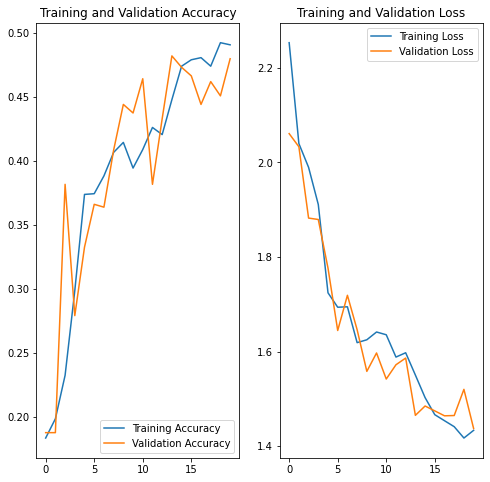

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model #2 Observations



1.   The training and validation accuracies are almost in same value range, training accuracy = 49.08% and  Validation accuracy= 47.99%
2.   Thus there is no Overfitting 
3.   This is a much better model than the previous one.
4.   But it is observed that overall accuracy is very less.
5.   We have to choose the right augmentation technique to improve accuracy.








### Checking for class imbalance

In [23]:
for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 466 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.




1.   We can see that there is a significant amount of class imbalance in the data.
2.   seborrheic keratosis has just 77 samples and has the least number of samples in the data.
3.  pigmented benign keratosis has 466 samples and has the most number of samples in the data.


Hence we need to use techniques like Data Augmentation to corrrect the class imbalance in data.






### Data Augmentation

In [24]:

!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [25]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1883AFA7C0>: 100%|██████████| 500/500 [00:22<00:00, 21.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1883A3D880>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1883AA4DF0>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F188DB44FD0>: 100%|██████████| 500/500 [01:52<00:00,  4.43 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x671 at 0x7F190C4EF580>: 100%|██████████| 500/500 [01:35<00:00,  5.25 Samples/s]


Initialised with 466 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1883A758B0>: 100%|██████████| 500/500 [00:22<00:00, 22.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F18F0051670>: 100%|██████████| 500/500 [00:47<00:00, 10.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1883A8C4F0>: 100%|██████████| 500/500 [00:24<00:00, 20.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1883ADE820>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0011139.jpg_6ec38011-426e-4520-b037-4ea551af9914.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010576.jpg_42827ace-e7b2-4490-8332-2026d61a4ecc.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010413.jpg_3d6fe5f1-0878-4e1d-b28b-49b290b597b0.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010934.jpg_7c56d30e-77cf-490e-984b-5dacdde17d43.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010081.jpg_316d7d3d-03b4-4fae-a110-8e3a2b5d7ec7.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_5cc5fca9-53a0-4f07-bca6-897c1776573a.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_6d5671af-de97-4b77-909c-b557e1f1a15e.jpg',
 'gdrive/My Drive/CNN_assignment/Train/melanoma/output/melanoma_origi

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [31]:

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')
    

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 966 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

### Create Training dataset

In [35]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6743 files belonging to 9 classes.
Using 5395 files for training.


### Create Validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6743 files belonging to 9 classes.
Using 1348 files for validation.


### Model #3

In [38]:
model_3=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Model Compilation

In [40]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

### Model training

In [41]:
epochs = 30

history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 39s 218ms/step - loss: 2.0851 - accuracy: 0.2782 - val_loss: 1.6915 - val_accuracy: 0.3872
Epoch 2/30
169/169 [==============================] - 35s 204ms/step - loss: 1.5352 - accuracy: 0.4182 - val_loss: 1.4788 - val_accuracy: 0.4570
Epoch 3/30
169/169 [==============================] - 39s 222ms/step - loss: 1.3481 - accuracy: 0.4982 - val_loss: 1.3351 - val_accuracy: 0.5193
Epoch 4/30
169/169 [==============================] - 36s 205ms/step - loss: 1.1648 - accuracy: 0.5679 - val_loss: 1.1491 - val_accuracy: 0.5764
Epoch 5/30
169/169 [==============================] - 34s 198ms/step - loss: 0.9858 - accuracy: 0.6413 - val_loss: 1.0045 - val_accuracy: 0.6439
Epoch 6/30
169/169 [==============================] - 36s 201ms/step - loss: 0.8640 - accuracy: 0.6905 - val_loss: 0.9380 - val_accuracy: 0.6721
Epoch 7/30
169/169 [==============================] - 36s 204ms/step - loss: 0.6939 - accuracy: 0.7572 - val_loss: 0.9226 - val_ac

### Visualizing the results

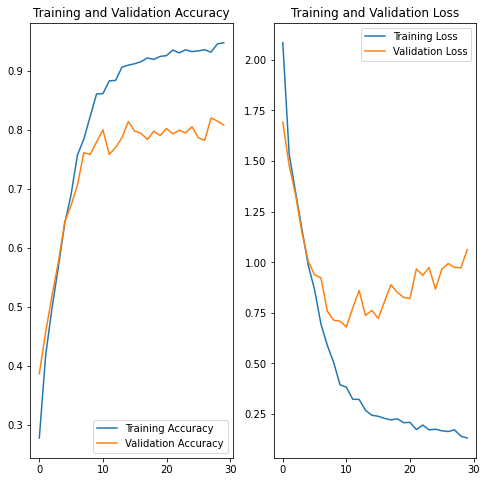

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



1.   After 30 epochs, training accuracy is 94.72% and validation accuracy is 80.79%
2.   Model accuracy has significantly improved
3.   Class imbalance is reduced.
4.   Overfitting is reduced


Now lets train the model using 50 epochs





In [43]:
epochs = 50

history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 38s 214ms/step - loss: 0.1412 - accuracy: 0.9424 - val_loss: 1.0383 - val_accuracy: 0.8116
Epoch 2/50
169/169 [==============================] - 37s 215ms/step - loss: 0.1526 - accuracy: 0.9416 - val_loss: 1.1407 - val_accuracy: 0.7901
Epoch 3/50
169/169 [==============================] - 40s 228ms/step - loss: 0.1540 - accuracy: 0.9409 - val_loss: 1.0555 - val_accuracy: 0.8056
Epoch 4/50
169/169 [==============================] - 36s 205ms/step - loss: 0.1431 - accuracy: 0.9509 - val_loss: 1.0891 - val_accuracy: 0.8042
Epoch 5/50
169/169 [==============================] - 39s 228ms/step - loss: 0.1622 - accuracy: 0.9399 - val_loss: 1.1108 - val_accuracy: 0.7915
Epoch 6/50
169/169 [==============================] - 35s 203ms/step - loss: 0.1336 - accuracy: 0.9462 - val_loss: 1.1372 - val_accuracy: 0.8168
Epoch 7/50
169/169 [==============================] - 38s 217ms/step - loss: 0.1504 - accuracy: 0.9414 - val_loss: 1.1615 - val_ac

Hence the model has significantly improved at 30 epochs itself (There is not much betterment in accuracy after 50 epochs). The model can further by optimized by adding more layers/changing epochs,batchsize etc.